# Inferring parameters of SDEs using a Euler-Maruyama scheme

_This notebook is derived from a presentation prepared for the Theoretical Neuroscience Group, Institute of Systems Neuroscience at Aix-Marseile University._

In [10]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt 
import scipy

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda/envs/pymc3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['trace', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Toy model 1

Here's a scalar linear SDE in symbolic form

$ dX_t = \lambda X_t + \sigma^2 dW_t $

discretized with the Euler-Maruyama scheme

In [11]:
# parameters
λ = -3.78
σ2 = 1e-2
N = 200
dt = 1e-1

# time series
x = 0.1
x_t = []

# simulate
for i in range(N):
    x += dt * λ * x + sqrt(dt) * σ2 * randn()
    x_t.append(x)
    
x_t = array(x_t)

# z_t noisy observation
z_t = x_t + randn(x_t.size) * 5e-3

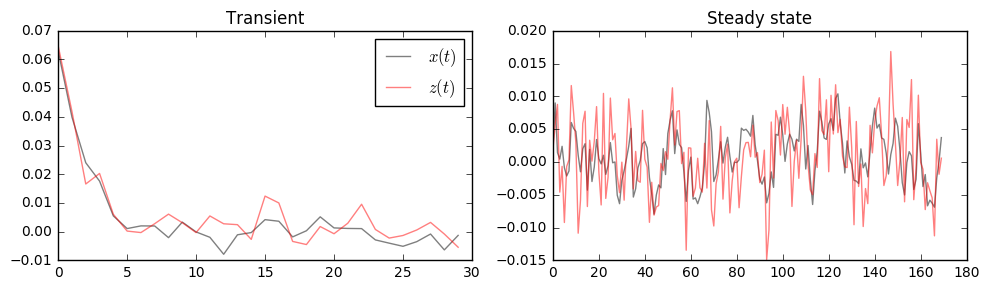

In [12]:
figure(figsize=(10, 3))
subplot(121)
plot(x_t[:30], 'k', label='$x(t)$', alpha=0.5), plot(z_t[:30], 'r', label='$z(t)$', alpha=0.5)
title('Transient'), legend()
subplot(122)
plot(x_t[30:], 'k', label='$x(t)$', alpha=0.5), plot(z_t[30:], 'r', label='$z(t)$', alpha=0.5)
title('Steady state');
tight_layout()

What is the inference we want to make? Since we've made a noisy observation of the generated time series, we need to estimate both $x(t)$ and $\lambda$.

First, we describe the distribution for our linear SDE, parametrized by the time step $dt$ and the damping parameter $\lambda$.

In [6]:
class LSDE(pm.Continuous):
    def __init__(self, dt, lam, *args, **kwargs):
        super(LSDE, self).__init__(*args, **kwargs)
        self.dt = dt
        self.lam = lam

    def logp(self, x):
        x_ = x[:-1]
        mu = x_ + self.dt * self.lam * x_
        return tt.sum(pm.Normal.dist(mu=mu, sd=σ2 * sqrt(dt)).logp(x[1:]))

Here, we compute the log probability by hand of a Monte Carlo sample `x`. 

_TODO show a graphical model explaining probability computation for time series_.

Finally, we can describe the probability model as a set of three stochastic variables, `lam`, `xh`, and `zh`:

In [7]:
with pm.Model() as model:
    
    # uniform prior, but we know it must be negative
    lam = pm.Flat('lam')
    
    # "hidden states" following a linear SDE distribution
    # parametrized by time step (det. variable) and lam (random variable)
    xh = LSDE('xh', dt, lam, shape=N, testval=x_t)
    
    # predicted observation
    zh = pm.Normal('zh', mu=xh, sd=5e-3, observed=z_t)

Once the model is constructed, we perform inference, i.e. sample from the posterior distribution, in the following steps:

In [8]:
with model:
    
    # optimize to find the mode of the posterior as starting point for prob. mass
    start = pm.find_MAP(vars=[xh], fmin=scipy.optimize.fmin_l_bfgs_b)

    # "warm up" to transition from mode to prob. mass
    step = pm.NUTS(scaling=start)
    trace = pm.sample(100, step, progressbar=True)

    # sample from the prob. mass
    step = pm.NUTS(scaling=trace[-1], gamma=.25)
    trace = pm.sample(2000, step, start=trace[-1], progressbar=True)

100%|██████████| 2000/2000 [00:04<00:00, 443.57it/s]


Next, we plot some basic statistics on the samples from the posterior,

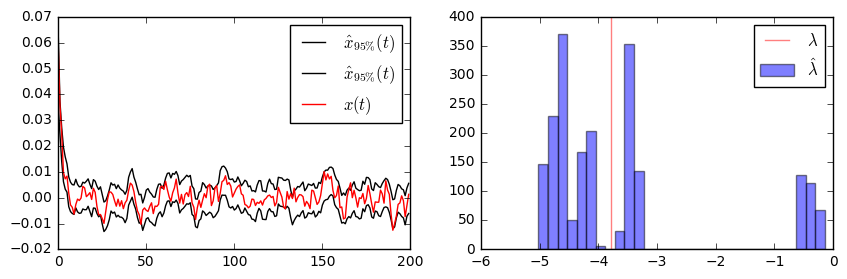

In [9]:
figure(figsize=(10, 3))
subplot(121)
plot(percentile(trace[xh], [2.5, 97.5], axis=0).T, 'k', label='$\hat{x}_{95\%}(t)$')
plot(x_t, 'r', label='$x(t)$')
legend()

subplot(122)
hist(trace[lam], 30, label='$\hat{\lambda}$', alpha=0.5)
axvline(λ, color='r', label='$\lambda$', alpha=0.5)
legend();

A model can fit the data precisely and still be wrong; we need to use _posterior predictive checks_ to assess if, under our fit model, the data our likely.

In other words, we 
- assume the model is correct
- simulate new observations
- check that the new observations fit with the original data

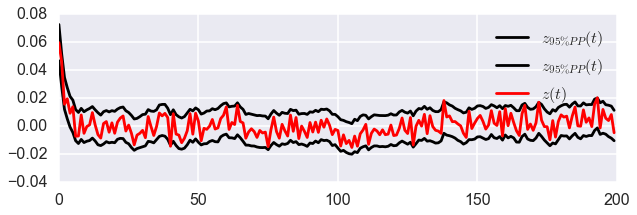

In [9]:
# generate trace from posterior
ppc_trace = pm.sample_ppc(trace, model=model)

# plot with data
figure(figsize=(10, 3))
plot(percentile(ppc_trace['zh'], [2.5, 97.5], axis=0).T, 'k', label=r'$z_{95\% PP}(t)$')
plot(z_t, 'r', label='$z(t)$')
legend()

Note that 

- inference also estimates the initial conditions
- the observed data $z(t)$ lies fully within the 95% interval of the PPC.
- there are many other ways of evaluating fit

### Toy model 2

As the next model, let's use a 2D deterministic oscillator, 
\begin{align}
\dot{x} &= \tau (x - x^3/3 + y) \\
\dot{y} &= \frac{1}{\tau} (a - x)
\end{align}

with noisy observation $z(t) = m x + (1 - m) y + N(0, 0.05)$.

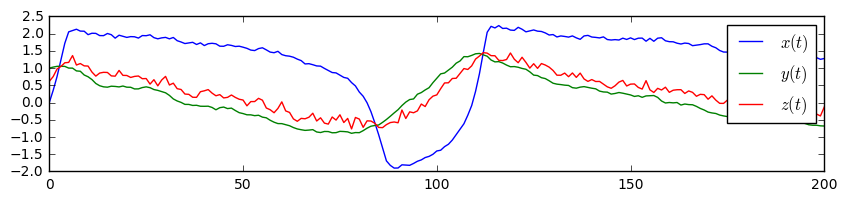

In [13]:
N, τ, a, m, σ2 = 200, 3.0, 1.05, 0.2, 1e-1
xs, ys = [0.0], [1.0]
for i in range(N):
    x, y = xs[-1], ys[-1]
    dx = τ * (x - x**3.0/3.0 + y)
    dy = (1.0 / τ) * (a - x)
    xs.append(x + dt * dx + sqrt(dt) * σ2 * randn())
    ys.append(y + dt * dy + sqrt(dt) * σ2 * randn())
xs, ys = array(xs), array(ys)
zs = m * xs + (1 - m) * ys + randn(xs.size) * 0.1

figure(figsize=(10, 2))
plot(xs, label='$x(t)$')
plot(ys, label='$y(t)$')
plot(zs, label='$z(t)$')
legend()

Now, estimate the hidden states $x(t)$ and $y(t)$, as well as parameters $\tau$, $a$ and $m$.

As before, we need to write a custom distribution for our model

In [14]:
class Osc2d(pm.Continuous):
    def __init__(self, τ, a, dt, *args, **kwds):
        super(Osc2d, self).__init__(*args, **kwds)
        self.τ = τ
        self.a = a
        self.dt = dt
    
    def logp(self, xy):
        x, y = xy[:-1, 0], xy[:-1, 1]
        x_mu = x + self.dt * self.τ * (x - x**3.0/3.0 + y)
        y_mu = y + self.dt * (1.0 / self.τ) * (self.a - x)
        mu = tt.stack([x_mu, y_mu], axis=0).T
        return tt.sum(pm.Normal.dist(mu=mu, sd=σ2 * sqrt(dt)).logp(xy[1:]))

As before, the Euler-Maruyama discretization of the SDE is written as a prediction of the state at step $i+1$ based on the state at step $i$.

We can now write our statistical model as before, with uninformative priors on $\tau$, $a$ and $m$:

In [15]:
xys = c_[xs, ys]

with pm.Model() as model:
    τh = pm.Uniform('τh', lower=0.1, upper=5.0)
    ah = pm.Uniform('ah', lower=0.5, upper=1.5)
    mh = pm.Uniform('mh', lower=0.0, upper=1.0)
    xyh = Osc2d('xyh', τh, ah, dt, shape=xys.shape, testval=xys)
    zh = pm.Normal('zh', mu=mh * xyh[:, 0] + (1 - mh) * xyh[:, 1], sd=0.1, observed=zs)

Applied interval-transform to τh and added transformed τh_interval_ to model.
Applied interval-transform to ah and added transformed ah_interval_ to model.
Applied interval-transform to mh and added transformed mh_interval_ to model.


As with the linear SDE, we 1) find a MAP estimate, 2) warm up and 3) sample from the probability mass:

In [16]:
with model:
    
    # optimize to find the mode of the posterior as starting point for prob. mass
    start = pm.find_MAP(vars=[xyh], fmin=scipy.optimize.fmin_l_bfgs_b)

    # "warm up" to transition from mode to prob. mass
    step = pm.NUTS(scaling=start)
    trace = pm.sample(100, step, progressbar=True)

    # sample from the prob. mass
    step = pm.NUTS(scaling=trace[-1], gamma=.25)
    trace = pm.sample(2000, step, start=trace[-1], progressbar=True)

100%|██████████| 2000/2000 [01:54<00:00, 17.47it/s]


Again, the result is a set of samples from the posterior, including our parameters of interest but also the hidden states

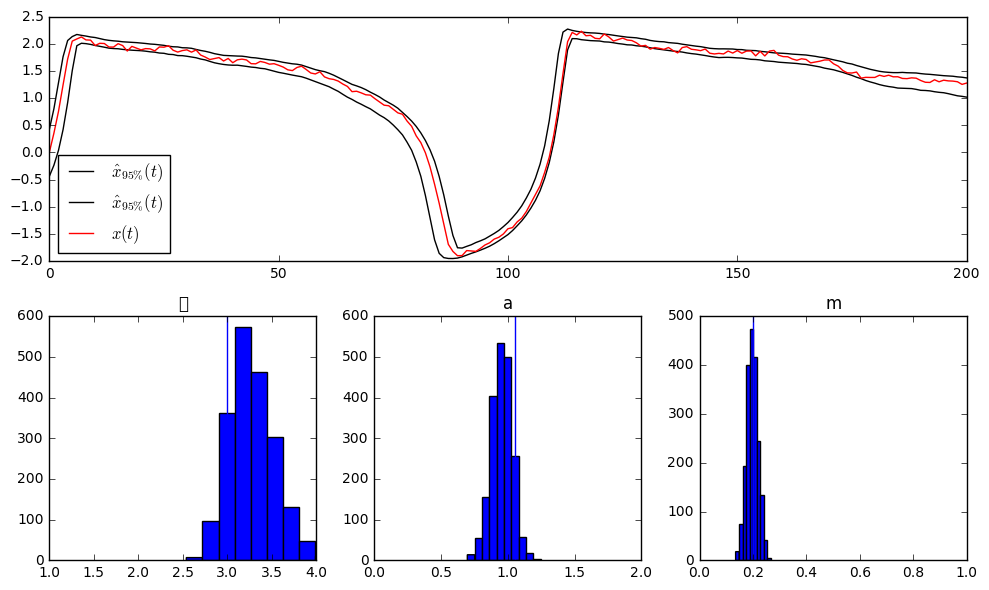

In [17]:
figure(figsize=(10, 6))
subplot(211)
plot(percentile(trace[xyh][..., 0], [2.5, 97.5], axis=0).T, 'k', label='$\hat{x}_{95\%}(t)$')
plot(xs, 'r', label='$x(t)$')
legend(loc=0)
subplot(234), hist(trace['τh']), axvline(τ), xlim([1.0, 4.0]), title('τ')
subplot(235), hist(trace['ah']), axvline(a), xlim([0, 2.0]), title('a')
subplot(236), hist(trace['mh']), axvline(m), xlim([0, 1]), title('m')
tight_layout()

Again, we can perform a posterior predictive check, that our data are likely given the fit model

100%|██████████| 2000/2000 [00:10<00:00, 197.07it/s]


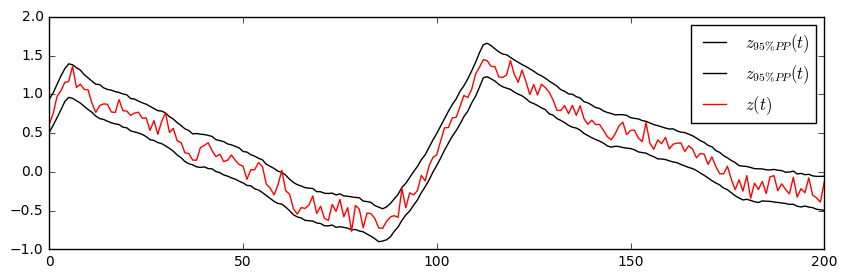

In [19]:
# generate trace from posterior
ppc_trace = pm.sample_ppc(trace, model=model)

# plot with data
figure(figsize=(10, 3))
plot(percentile(ppc_trace['zh'], [2.5, 97.5], axis=0).T, 'k', label=r'$z_{95\% PP}(t)$')
plot(zs, 'r', label='$z(t)$')
legend()